In [63]:
import xml.etree.ElementTree as ET
#from lxml import etree
import pandas as pd
import time
import numpy as np
import datetime as dt
# dt.datetime.strptime

In [64]:
# create element tree object

tree = ET.parse('data/export.xml') 
# for every health record, extract the attributes into a dictionary (columns). Then create a list (rows)
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

# create DataFrame from a list (rows) of dictionaries (columns)
record_data = pd.DataFrame(record_list)

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    record_data[col] = pd.to_datetime(record_data[col])

# value is numeric, NaN if fails
record_data['value'] = pd.to_numeric(record_data['value'], errors='coerce')

# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
record_data['value'] = record_data['value'].fillna(1.0)

# shorter observation names: use vectorized replace function
record_data['type'] = record_data['type'].str.replace('HKQuantityTypeIdentifier', '')
record_data['type'] = record_data['type'].str.replace('HKCategoryTypeIdentifier', '')

In [65]:
record_data.tail()

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
743765,HeartRateVariabilitySDNN,Apple Watch von Patrick,7.6.1,ms,2021-08-20 21:44:34+02:00,2021-08-20 21:43:28+02:00,2021-08-20 21:44:34+02:00,106.2270,"<<HKDevice: 0x2811a01e0>, name:Apple Watch, ma..."
743766,HeartRateVariabilitySDNN,Apple Watch von Patrick,7.6.1,ms,2021-08-20 21:48:35+02:00,2021-08-20 21:47:30+02:00,2021-08-20 21:48:35+02:00,60.9539,"<<HKDevice: 0x2811a01e0>, name:Apple Watch, ma..."
743767,HeartRateVariabilitySDNN,Apple Watch von Patrick,7.6.1,ms,2021-08-22 08:19:29+02:00,2021-08-22 08:18:23+02:00,2021-08-22 08:19:29+02:00,71.2487,"<<HKDevice: 0x2811a01e0>, name:Apple Watch, ma..."
743768,HeartRateVariabilitySDNN,Apple Watch von Patrick,7.6.1,ms,2021-08-22 09:52:59+02:00,2021-08-22 09:51:54+02:00,2021-08-22 09:52:59+02:00,87.2668,"<<HKDevice: 0x2811a01e0>, name:Apple Watch, ma..."
743769,HeartRateVariabilitySDNN,Apple Watch von Patrick,7.6.1,ms,2021-08-22 14:00:49+02:00,2021-08-22 13:59:45+02:00,2021-08-22 14:00:49+02:00,42.2700,"<<HKDevice: 0x2811a01e0>, name:Apple Watch, ma..."


In [66]:
record_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743770 entries, 0 to 743769
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype                                
---  ------         --------------   -----                                
 0   type           743770 non-null  object                               
 1   sourceName     743770 non-null  object                               
 2   sourceVersion  738284 non-null  object                               
 3   unit           739683 non-null  object                               
 4   creationDate   743770 non-null  datetime64[ns, pytz.FixedOffset(120)]
 5   startDate      743770 non-null  datetime64[ns, pytz.FixedOffset(120)]
 6   endDate        743770 non-null  datetime64[ns, pytz.FixedOffset(120)]
 7   value          743770 non-null  float64                              
 8   device         697925 non-null  object                               
dtypes: datetime64[ns, pytz.FixedOffset(120)](3), float64(1), obj

In [67]:
workout_list = [x.attrib for x in root.iter('Workout')]

# create DataFrame from a list (rows) of dictionaries (columns)
workout_data = pd.DataFrame(workout_list)
workout_data['workoutActivityType'] = workout_data['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
workout_data = workout_data.rename({"workoutActivityType": "Type"}, axis=1)
# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    workout_data[col] = pd.to_datetime(workout_data[col])
    
workout_data['duration'] = pd.to_numeric(workout_data['duration'])
workout_data['totalEnergyBurned'] = pd.to_numeric(workout_data['totalEnergyBurned'])
workout_data['totalDistance'] = pd.to_numeric(workout_data['totalDistance'])
workout_data.tail()

,Type,duration,durationUnit,totalDistance,totalDistanceUnit,totalEnergyBurned,totalEnergyBurnedUnit,sourceName,sourceVersion,device,creationDate,startDate,endDate
180,Running,18.876555,min,3.026288,km,202.358105,kcal,Apple Watch von Patrick,7.2,"<<HKDevice: 0x2811cf160>, name:Apple Watch, ma...",2021-08-18 08:08:20+02:00,2021-08-18 07:49:27+02:00,2021-08-18 08:08:19+02:00
181,Running,41.686440,min,7.154993,km,481.677116,kcal,Apple Watch von Patrick,7.2,"<<HKDevice: 0x2811cf160>, name:Apple Watch, ma...",2021-08-19 09:49:37+02:00,2021-08-19 09:07:54+02:00,2021-08-19 09:49:36+02:00
182,Running,19.186911,min,3.028681,km,201.441305,kcal,Apple Watch von Patrick,7.6.1,"<<HKDevice: 0x2811da490>, name:Apple Watch, ma...",2021-08-20 19:03:11+02:00,2021-08-20 18:43:58+02:00,2021-08-20 19:03:09+02:00
183,Running,20.134952,min,3.035656,km,199.521000,kcal,Apple Watch von Patrick,7.6.1,"<<HKDevice: 0x2811da490>, name:Apple Watch, ma...",2021-08-21 17:29:21+02:00,2021-08-21 17:09:11+02:00,2021-08-21 17:29:19+02:00
184,Yoga,22.080947,min,0.000000,km,50.902514,kcal,Apple Watch von Patrick,7.6.1,"<<HKDevice: 0x2811da490>, name:Apple Watch, ma...",2021-08-22 08:47:27+02:00,2021-08-22 08:25:21+02:00,2021-08-22 08:47:26+02:00


In [68]:
last_run = workout_data.iloc[[-2]]
last_run

,Type,duration,durationUnit,totalDistance,totalDistanceUnit,totalEnergyBurned,totalEnergyBurnedUnit,sourceName,sourceVersion,device,creationDate,startDate,endDate
183,Running,20.134952,min,3.035656,km,199.521,kcal,Apple Watch von Patrick,7.6.1,"<<HKDevice: 0x2811da490>, name:Apple Watch, ma...",2021-08-21 17:29:21+02:00,2021-08-21 17:09:11+02:00,2021-08-21 17:29:19+02:00


In [69]:
def get_heartrate_for_date(start, end, heartrate):
    heartrate = heartrate[heartrate["startDate"] >= start]
    heartrate = heartrate[heartrate["endDate"] <= end]
    return heartrate

def get_heartrate_for_workout(workout, heartrate):
    return get_heartrate_for_date(workout["startDate"].item(), workout["endDate"].item(), heartrate)

In [70]:
heartrate = record_data[record_data["type"] == "HeartRate"]

heartrate = get_heartrate_for_workout(last_run, heartrate)
minh = heartrate["value"].min()
maxh = heartrate["value"].max()
meanh = heartrate["value"].mean()
minh, maxh, meanh

(73.0, 136.0, 125.71784232365145)

<AxesSubplot:xlabel='endDate'>

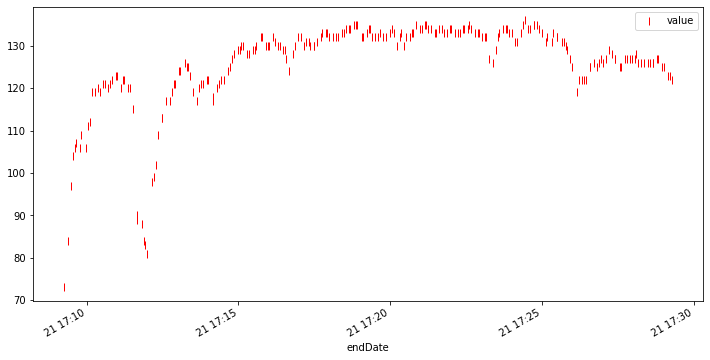

In [71]:
heartrate.plot(x='endDate', y='value', style='r|', markersize=8.5,  figsize=(12, 6))

In [72]:
today = dt.date.today()

xdaysago = today - dt.timedelta(days=7)
first_of_month = today - dt.timedelta(days=today.day - 1)

In [73]:
today

datetime.date(2021, 8, 22)

In [74]:
xdaysago

datetime.date(2021, 8, 15)

In [75]:
first_of_month

datetime.date(2021, 8, 1)

In [76]:
xdaysago = today - dt.timedelta(days=33)

time_to_check = pd.to_datetime(first_of_month, utc=True)
time_to_check = pd.to_datetime(xdaysago, utc=True)
runs_last_month = workout_data[workout_data["creationDate"] >= time_to_check]
runs_last_month = runs_last_month[runs_last_month["Type"] == "Running"]
runs_last_month = runs_last_month.drop(columns=["device", "sourceVersion"])

In [77]:
duration_sum = runs_last_month["duration"].sum()
distance_sum = runs_last_month["totalDistance"].sum()
energy_sum = runs_last_month["totalEnergyBurned"].sum()
duration_sum, distance_sum, energy_sum

(755.4174678126972, 129.0223653750448, 8521.206610642746)

In [78]:
duration_avg = runs_last_month["duration"].mean()
distance_avg = runs_last_month["totalDistance"].mean()
energy_avg = runs_last_month["totalEnergyBurned"].mean()
duration_avg, distance_avg, energy_avg

(22.89143841856658, 3.909768647728631, 258.2183821406893)

In [79]:
def get_heartrate_for_workout(workout, heartrate):
    return get_heartrate_for_date(workout["startDate"], workout["endDate"], heartrate)

def convert_to_minute_proportion(number):
    return int(number) + ((number % 1) / 100 * 60)
heartrate = record_data[record_data["type"] == "HeartRate"]
runs_last_month["heartrate"] = runs_last_month.apply(lambda row: get_heartrate_for_workout(row, heartrate), axis=1)
runs_last_month["hr_mean"] = runs_last_month.apply(lambda row: row['heartrate']["value"].mean(), axis=1)
pace = runs_last_month["duration"] / runs_last_month["totalDistance"]
# convert decimals to minute percentage, pace=min/km
pace = pace.apply(lambda row: convert_to_minute_proportion(row))
runs_last_month["pace"] = pace

In [80]:
import matplotlib.pyplot as plt

plot_data = runs_last_month[['duration', 'totalDistance', 'totalEnergyBurned', 'creationDate']].copy()
plot_data.head()

,duration,totalDistance,totalEnergyBurned,creationDate
150,24.017083,4.021084,263.423771,2021-07-20 17:48:58+02:00
151,23.304460,4.025121,261.674000,2021-07-21 17:35:13+02:00
152,22.919020,4.027181,268.220008,2021-07-22 17:04:27+02:00
153,23.090579,4.281389,276.979934,2021-07-23 17:49:31+02:00
154,24.015762,4.119525,269.036218,2021-07-24 17:57:31+02:00


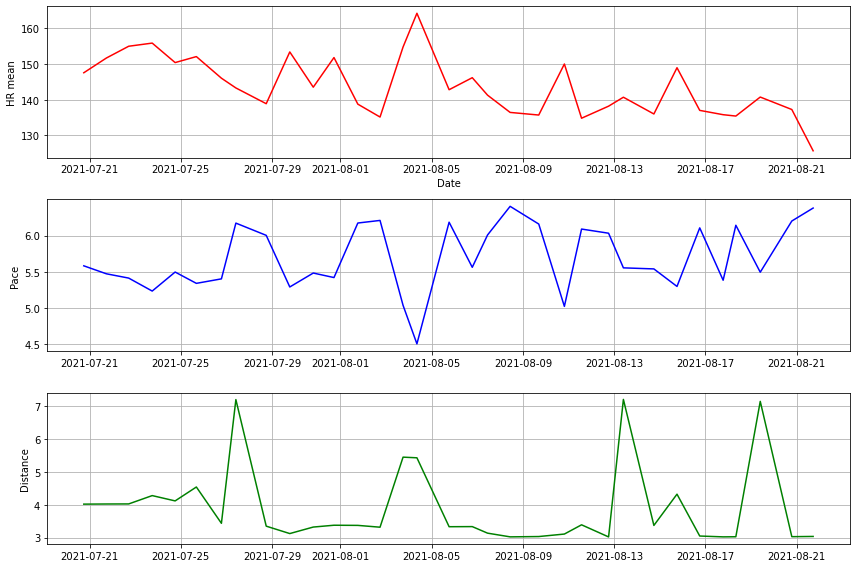

In [81]:
# plot hr, pace, distance
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

x = runs_last_month['creationDate']
axs[0].plot(x, runs_last_month["hr_mean"], color="red")
axs[0].set_xlabel('Date')
axs[0].set_ylabel('HR mean')
axs[0].grid(True)

axs[1].plot(x, runs_last_month["pace"], color="blue")
axs[1].set_ylabel('Pace')
axs[1].grid(True)

axs[2].plot(x, runs_last_month["totalDistance"], color="green")
axs[2].set_ylabel('Distance')
axs[2].grid(True)

fig.tight_layout()
plt.show()

In [82]:
# Get stats
total_dist = runs_last_month["totalDistance"].sum()
total_time = runs_last_month["duration"].sum() / 60
total_time = convert_to_minute_proportion(total_time)
total_kcal = runs_last_month["totalEnergyBurned"].sum()
hr_mean = runs_last_month["hr_mean"].mean()
pace_mean = (runs_last_month["duration"] / runs_last_month["totalDistance"]).mean()
pace_mean = convert_to_minute_proportion(pace_mean)
total_dist, total_time, total_kcal, hr_mean, pace_mean

(129.0223653750448,
 12.354174678126972,
 8521.206610642746,
 143.81744261405984,
 5.534279971791522)